In [1]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import plotly.express as px

In [2]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

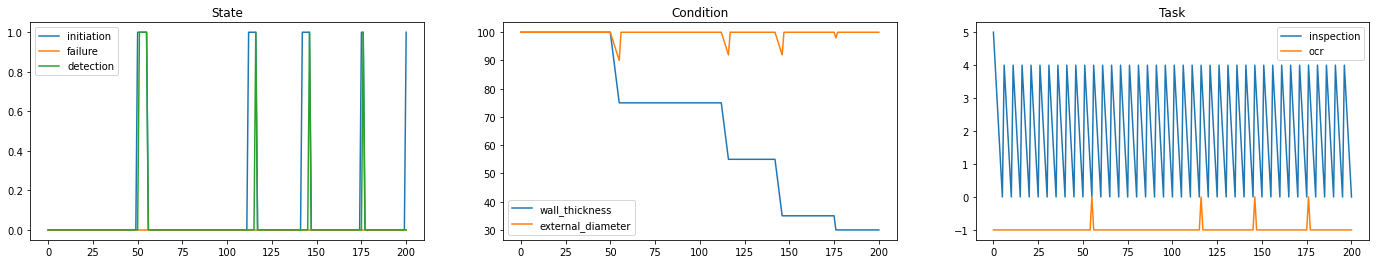

In [3]:
timeline = fm.sim_timeline(200, verbose=False)
fm.plot_timeline()

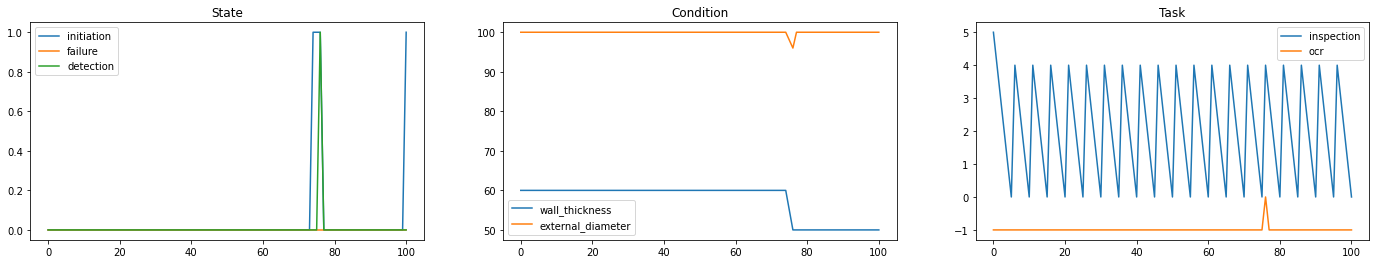

In [4]:
fm.conditions['wall_thickness'].set_condition(60)
fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(100)
fm.plot_timeline()

In [5]:
for i in tqdm(range(10)):
    fm.sim_timeline(200)

100%|██████████| 10/10 [00:00<00:00, 56.82it/s]


In [6]:
df = fm.expected_cost_df()

In [7]:
fig = px.area(df, x="time", y="cost_cumulative", color="task")
fig.show()

In [8]:
df = fm.expected_cost_df()

In [14]:
new_index = pd.Index(np.arange(0,200,1), name="time")

df = df.loc[df['task']=='ocr']

df = df.set_index('time').reindex(new_index).reset_index()
df.loc[0,:] = 0
df.loc[0,'task'] = 'ocr'
df = df.fillna(method='ffill')
df

,time,task,cost,cost_cumulative
0,0,ocr,0.000000,0.000000
1,1,ocr,0.000000,0.000000
2,2,ocr,0.000000,0.000000
3,3,ocr,0.000000,0.000000
4,4,ocr,0.000000,0.000000
...,...,...,...,...
195,195,ocr,8.333333,283.333333
196,196,ocr,8.333333,283.333333
197,197,ocr,8.333333,283.333333
198,198,ocr,8.333333,283.333333
